In [25]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.losses import mse, BinaryCrossentropy

from convertors import momentums_to_angles

In [26]:
%matplotlib inline

In [27]:
pd.options.display.max_columns = 15
np.random.seed(111)
tf.random.set_seed(111)

In [28]:
df = pd.read_csv('Data/monte_carlo_dataset.csv')

dataset = df.to_numpy()[:, 1:]
dataset.shape

(100000, 10)

In [29]:
num_of_samples = dataset.shape[0]
input_shape = dataset.shape[1]
latent_size = 4
EPOCHS = 75
BATCH_SIZE = 1024
num_examples_to_generate = 100000

In [30]:
scaler = MinMaxScaler()
scaler.fit(dataset)

MinMaxScaler()

In [31]:
def normalise(data):
    return scaler.transform(data)

def denormalise(data):
    return scaler.inverse_transform(data)

In [32]:
def generator_model():
    model = Sequential()
    model.add(Input(shape=(latent_size, )))
    model.add(Dense(7, use_bias=False))
    model.add(LeakyReLU())

    model.add(Dense(8, use_bias=False))
    model.add(LeakyReLU())

    model.add(Dense(9, use_bias=False))
    model.add(LeakyReLU())

    model.add(Dense(input_shape, use_bias=False, activation='tanh'))

    return model

In [33]:
def discriminator_model():
    model = Sequential()
    model.add(Input(shape=(input_shape, )))

    model.add(Dense(8))
    model.add(LeakyReLU())

    model.add(Dense(6))
    model.add(LeakyReLU())

    model.add(Dense(3))
    model.add(LeakyReLU())

    model.add(Dense(1))

    return model

In [34]:
generator = generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 7)                 28        
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7)                 0         
                                                                 
 dense_7 (Dense)             (None, 8)                 56        
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 9)                 72        
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 9)                 0         
                                                                 
 dense_9 (Dense)             (None, 10)               

In [35]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 88        
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 6)                 54        
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 6)                 0         
                                                                 
 dense_12 (Dense)            (None, 3)                 21        
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 3)                 0         
                                                                 
 dense_13 (Dense)            (None, 1)                

In [36]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [37]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [39]:
seed = tf.random.normal([num_examples_to_generate, latent_size])

In [40]:
# `tf.function` annotation causes the function to be "compiled"
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_size])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [41]:
generator = load_model('Model/dgan_generator.hdf5')
discriminator = load_model('Model/dgan_discriminator.hdf5')

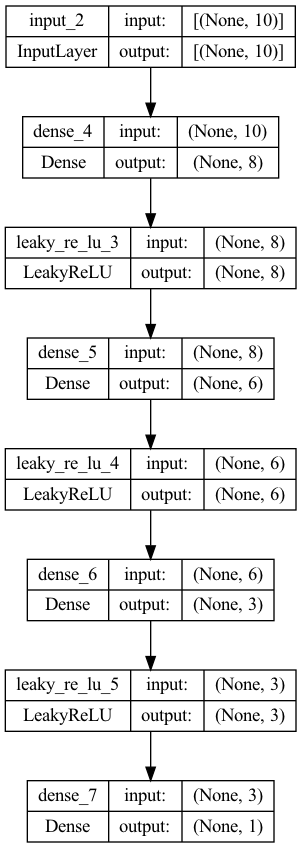

In [42]:
tf.keras.utils.plot_model(generator, to_file='Plots/generator.png', show_shapes=True)
tf.keras.utils.plot_model(discriminator, to_file='Plots/discriminator.png', show_shapes=True)